<a href="https://colab.research.google.com/github/hasanzeynal/Deep-Learning-Recipes/blob/main/Keras-Journey/01%20-%20modelling_on_tabular_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy.stats import norm
import pylab

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.metrics import Accuracy
from keras.layers import Dense,Flatten
from keras.optimizers import SGD
from keras.losses import categorical_crossentropy
from keras.callbacks import EarlyStopping

# Data Preperation

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/datasets/heart_disease_dataset.csv',sep=';')
df.head()

age  sex  chest_pain_type  resting_blood_pressure  cholesterol  \
0   63    1                3                     145          233   
1   37    1                2                     130          250   
2   41    0                1                     130          204   
3   56    1                1                     120          236   
4   57    0                0                     120          354   

   fasting_blood_sugar  rest_ecg  max_heart_rate_achieved  \
0                    1         0                      150   
1                    0         1                      187   
2                    0         0                      172   
3                    0         1                      178   
4                    0         1                      163   

   exercise_induced_angina  st_depression  st_slope  num_major_vessels  \
0                        0            2.3         0                  0   
1                        0            3.5         0                  0   
2                        0            1.4         2                  0   
3                        0            0.8         2                  0   
4                        1            0.6         2                  0   

   thalassemia  target  
0            1       1  
1            2       1  
2            2       1  
3            2       1  
4            2       1

In [ ]:
print(f'The number of features that has null values:{df.isnull().any().sum()}')

The number of features that has null values:0


In [ ]:
for col in df.columns:
  if len(dict(df[col].value_counts()).keys()) <= 5:
    print(f'{col}:{df[col].nunique()}')

sex:2
chest_pain_type:4
fasting_blood_sugar:2
rest_ecg:3
exercise_induced_angina:2
st_slope:3
num_major_vessels:5
thalassemia:4
target:2


*Visualization with pie chart to show how distribute our data in categorical features* 

---
let's get started


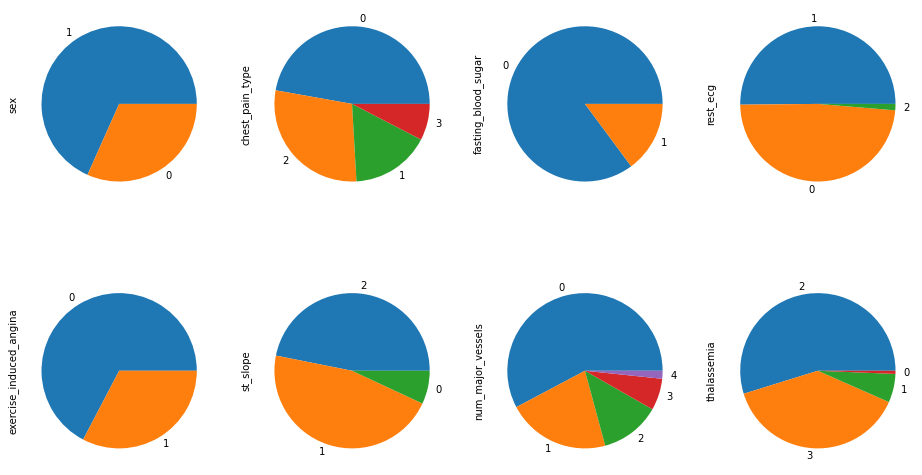

In [ ]:
cat_features_1 = ['sex','chest_pain_type','fasting_blood_sugar','rest_ecg']
cat_features_2 = ['exercise_induced_angina','st_slope','num_major_vessels','thalassemia']

fig,ax = plt.subplots(2,4,figsize=(16,9))

for j in range(0, 2):
  if j == 0:
    for i,c in enumerate(cat_features_1):
      df[c].value_counts().plot(kind='pie', ax=ax[j][i])
  else:
    for i,c in enumerate(cat_features_2):
      df[c].value_counts().plot(kind='pie', ax=ax[j][i])

In [ ]:
df.shape

(303, 14)


**As we can see,there is no any problem than can be caused inbalance**



# Detecting and Handling outliers

In [ ]:
df.describe().T

count        mean        std    min    25%    50%  \
age                      303.0   54.366337   9.082101   29.0   47.5   55.0   
sex                      303.0    0.683168   0.466011    0.0    0.0    1.0   
chest_pain_type          303.0    0.966997   1.032052    0.0    0.0    1.0   
resting_blood_pressure   303.0  131.623762  17.538143   94.0  120.0  130.0   
cholesterol              303.0  246.264026  51.830751  126.0  211.0  240.0   
fasting_blood_sugar      303.0    0.148515   0.356198    0.0    0.0    0.0   
rest_ecg                 303.0    0.528053   0.525860    0.0    0.0    1.0   
max_heart_rate_achieved  303.0  149.646865  22.905161   71.0  133.5  153.0   
exercise_induced_angina  303.0    0.326733   0.469794    0.0    0.0    0.0   
st_depression            303.0    1.039604   1.161075    0.0    0.0    0.8   
st_slope                 303.0    1.399340   0.616226    0.0    1.0    1.0   
num_major_vessels        303.0    0.729373   1.022606    0.0    0.0    0.0   
thalassemia              303.0    2.313531   0.612277    0.0    2.0    2.0   
target                   303.0    0.544554   0.498835    0.0    0.0    1.0   

                           75%    max  
age                       61.0   77.0  
sex                        1.0    1.0  
chest_pain_type            2.0    3.0  
resting_blood_pressure   140.0  200.0  
cholesterol              274.5  564.0  
fasting_blood_sugar        0.0    1.0  
rest_ecg                   1.0    2.0  
max_heart_rate_achieved  166.0  202.0  
exercise_induced_angina    1.0    1.0  
st_depression              1.6    6.2  
st_slope                   2.0    2.0  
num_major_vessels          1.0    4.0  
thalassemia                3.0    3.0  
target                     1.0    1.0

Actually,we need to see outliers in the boxplot,so i have showed the description of datas,It seems that,Median would be best choise to show boxplots

In [ ]:
cat_features_1 + cat_features_2

['sex',
 'chest_pain_type',
 'fasting_blood_sugar',
 'rest_ecg',
 'exercise_induced_angina',
 'st_slope',
 'num_major_vessels',
 'thalassemia']

In [ ]:
numeric_features = ['age','cholesterol','max_heart_rate_achieved','resting_blood_pressure',
                    'st_depression','thalassemia']

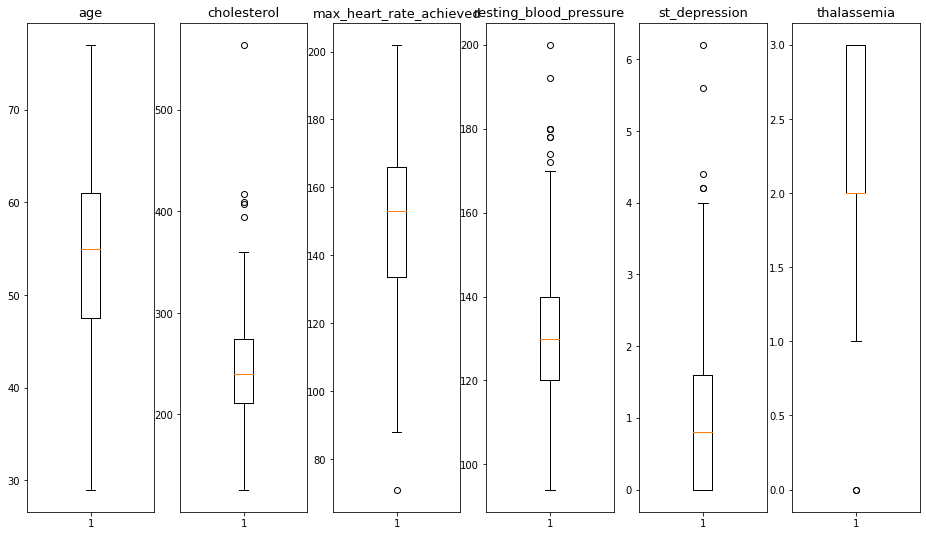

In [ ]:
fig,axes = plt.subplots(1,6,figsize=(16,9))
#sns.set_style('whitegrid')
for i,f in enumerate(numeric_features):
    axes[i].boxplot(df[f])
    axes[i].set_title(f).set_fontsize(13)
    #_ = axes[f].set_ylabel('')
#_ = plt.tight_layout()
# ask someone,how to get title name 

In [ ]:
#detecting outliers
df_copy = df.copy()
for col in numeric_features:
  print(f"Upper allowed for the {col}:{df[col].mean() + 3*df[col].std()}")
  print(f"Lower allowed for the {col}:{df[col].mean() - 3*df[col].std()}")

Upper allowed for the age:81.61263960317694
Lower allowed for the age:27.120033664149794
Upper allowed for the cholesterol:401.75627936643036
Lower allowed for the cholesterol:90.77177343885018
Upper allowed for the max_heart_rate_achieved:218.36234803121096
Lower allowed for the max_heart_rate_achieved:80.93138134172638
Upper allowed for the resting_blood_pressure:184.23819081678894
Lower allowed for the resting_blood_pressure:79.00933393568633
Upper allowed for the st_depression:4.5228290266019435
Lower allowed for the st_depression:-2.4436211058098647
Upper allowed for the thalassemia:4.150360874969737
Lower allowed for the thalassemia:0.47670183130089105


In [ ]:
for col in numeric_features:
  print(f"{col}:{round(df[col].skew(),2)}")

age:-0.2
cholesterol:1.14
max_heart_rate_achieved:-0.54
resting_blood_pressure:0.71
st_depression:1.27
thalassemia:-0.48


In [ ]:
for col in numeric_features:
  Q3 = np.percentile(df[col], 75, interpolation = 'midpoint')
  Q1 = np.percentile(df[col], 25, interpolation = 'midpoint')
  df[col] = np.where(df[col] < Q1, Q1,df[col])
  df[col] = np.where(df[col] > Q3,Q3,df[col])
  print(f'{col}:{df[col].skew()}')

age:-0.12304843034217994
cholesterol:0.04060469119663337
max_heart_rate_achieved:-0.18347656908522
resting_blood_pressure:-0.007672609263591587
st_depression:0.0748778614705752
thalassemia:0.47006506722070385


In [ ]:
df.shape

(303, 14)

In [ ]:
#the shape is same because we didnot delete the outliers,j
#ust change them to the max and min values and high skewnes changed to the low one.tjat is a good thing

# Visalizations to get inside about datas

## Checing for normalization



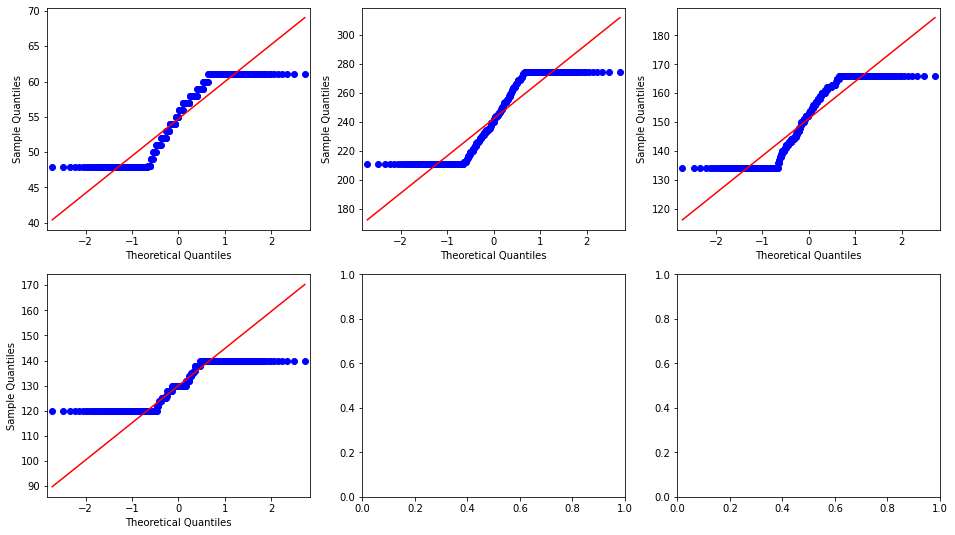

In [ ]:
fig,ax = plt.subplots(2,3,figsize=(16,9))
for j in range(0, 2):
  if j == 0:
    for i,c in enumerate(['age','cholesterol','max_heart_rate_achieved']):
      sm.qqplot(df[c],ax=ax[j][i],line = 's')
  else:
    for i,c in enumerate(['resting_blood_pressure','st_depression','thalassemia']):
      sm.qqplot(df[c],ax=ax[j][i],line = 'q')
      pylab.show()

In [ ]:
df.head()

age  sex  chest_pain_type  resting_blood_pressure  cholesterol  \
0  61.0000  1.0              2.0                   140.0     233.0000   
1  47.9375  1.0              2.0                   130.0     250.0000   
2  47.9375  0.0              1.0                   130.0     211.0000   
3  56.0000  1.0              1.0                   120.0     236.0000   
4  57.0000  0.0              0.0                   120.0     274.0625   

   fasting_blood_sugar  rest_ecg  max_heart_rate_achieved  \
0                  0.0       0.0                    150.0   
1                  0.0       1.0                    166.0   
2                  0.0       0.0                    166.0   
3                  0.0       1.0                    166.0   
4                  0.0       1.0                    163.0   

   exercise_induced_angina  st_depression  st_slope  num_major_vessels  \
0                      0.0            1.6       1.0                0.0   
1                      0.0            1.6       1.0                0.0   
2                      0.0            1.4       2.0                0.0   
3                      0.0            0.8       2.0                0.0   
4                      1.0            0.6       2.0                0.0   

   thalassemia  target  
0          2.0     1.0  
1          2.0     1.0  
2          2.0     1.0  
3          2.0     1.0  
4          2.0     1.0

## Checking for correlation

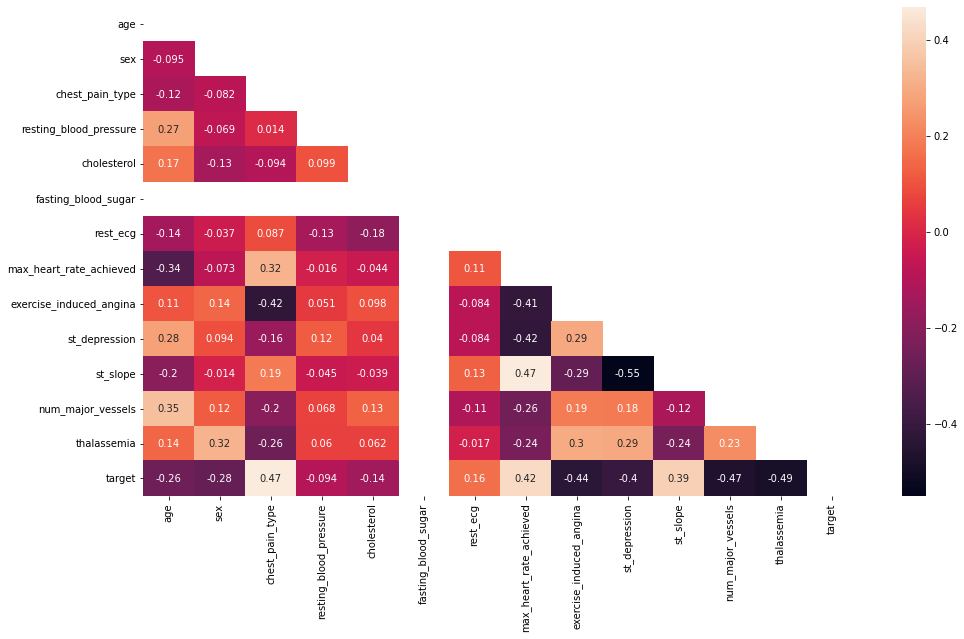

In [ ]:
plt.figure(figsize=(16,9))
corr = df.corr()
matrix = np.triu(corr)
sns.heatmap(corr,annot=True,mask=matrix)
plt.show()

# Train Test Splitting

In [ ]:
X = df.iloc[:,:-1]
y = df.drop(df.iloc[:,:-1],axis=1)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=21)

# Feature Scalling on indepented features

In [ ]:
rs=RobustScaler()
X = rs.fit_transform(X)

# Building model with keras

In [ ]:
model = Sequential()

model.add(Dense(32,activation='relu',input_shape=(13,)))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,'sigmoid'))

In [ ]:
model.compile(loss='binary_crossentropy',optimizer=SGD(lr=0.01),metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
history = model.fit(X,y,epochs=20,
          batch_size=12,
          #callbacks=EarlyStopping(patience=5),
          validation_split=0.2)

Epoch 1/20
21/21 [==============================] - 4s 12ms/step - loss: 0.6741 - accuracy: 0.6033 - val_loss: 0.6663 - val_accuracy: 0.7049
Epoch 2/20
21/21 [==============================] - 0s 5ms/step - loss: 0.6498 - accuracy: 0.7893 - val_loss: 0.7083 - val_accuracy: 0.3607
Epoch 3/20
21/21 [==============================] - 0s 5ms/step - loss: 0.6279 - accuracy: 0.8058 - val_loss: 0.7391 - val_accuracy: 0.2787
Epoch 4/20
21/21 [==============================] - 0s 7ms/step - loss: 0.6096 - accuracy: 0.7975 - val_loss: 0.7725 - val_accuracy: 0.1475
Epoch 5/20
21/21 [==============================] - 0s 5ms/step - loss: 0.5923 - accuracy: 0.7769 - val_loss: 0.7918 - val_accuracy: 0.0984
Epoch 6/20
21/21 [==============================] - 0s 5ms/step - loss: 0.5768 - accuracy: 0.7769 - val_loss: 0.8117 - val_accuracy: 0.0656
Epoch 7/20
21/21 [==============================] - 0s 5ms/step - loss: 0.5627 - accuracy: 0.7645 - val_loss: 0.8260 - val_accuracy: 0.0820
Epoch 8/20
21/21 [=

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                448       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,625
Trainable params: 2,625
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

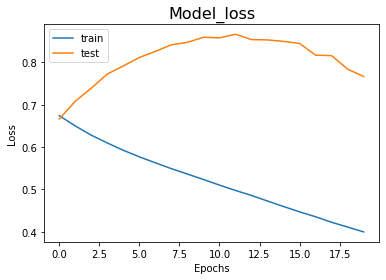

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model_loss',fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train','test'])
plt.show()

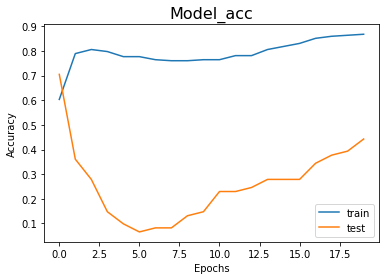

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model_acc',fontsize=16)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train','test'])
plt.show()